# Tarea 1 - Alexandre Poupeau

First, we need to import some useful libraries that we will use in the notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

## Exercice 1 - Verisimilitude Maximal

The idea is basic. We suppose that all the estimations come from a normal distribution with the same mean but a different variance. So we can write that $Y_i \sim \mathcal{N}(\mu,\,\sigma^{2}_i)$, where $Y_i$ describes the expected estimation of the scientist $i$. In this experience, there $n=7$ scientists that made an estimation.

$l(\mu) = p(data | model) = \displaystyle \prod^n_{i=1} p(data_i|model_i) = \displaystyle \prod^n_{i=1} p(y_i|Y_i \sim \mathcal{N}(\mu,\,\sigma^{2}_i)) = \displaystyle \prod^n_{i=1} \dfrac{1}{\sqrt{2\pi\sigma_i^2}} \exp(-\dfrac{1}{2\sigma_i^2}(y_i-\mu)^2)$

In [2]:
# estimation of the seven scientists
estimations = [-27.020, 3.57, 8.191, 9.898, 9.603, 9.945, 10.056]

In [3]:
def verisimilitude(y, var, mu):
    """
        Calculate the verisimilitude for a given mu.
    
        Arguments:
            y (array) : estimations of the scientists
            sigmas (array) : sample variance for every y_i
            mu (float) : value of the mean in the normal distributions.
    
        Returns:
            l_mu (float) : Verisimilitude
    """
    l_mu = 1
    for y_i, var_i in zip(y, var):
        l_mu *= (1/np.sqrt(2*np.pi*var_i))*np.exp(-(1/(2*var_i))*(y_i-mu)**2)
    return l_mu

Before maximazing $l(\mu)$ we need to find values for each $\sigma_i$ that make sense. In order to achieve that, we are going to compute the sample (or also called empirical) mean and variance.

Sample mean (without taking into account the estimation of the first and second scientists) : 9.538599999999999
Sample variances : [1.33653123e+03 3.56241860e+01 1.81602576e+00 1.29168360e-01
 4.14736000e-03 1.65160960e-01 2.67702760e-01]


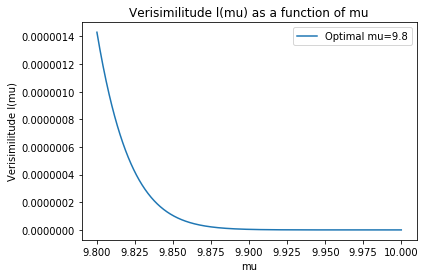

In [4]:
sample_mean = np.mean(estimations[2:])
sample_variances = (estimations-sample_mean)**2

print("Sample mean (without taking into account the estimation of the first and second scientists) :", sample_mean)
print("Sample variances :", sample_variances)

mu_array = np.linspace(9.8, 10, 1000) # 9.35, 9.9

l_mu_stock = list()
for mu in mu_array:
    l_mu_stock.append([mu, verisimilitude(estimations, sample_variances, mu)])
l_mu_stock = np.array(l_mu_stock)

optimal_mu = l_mu_stock[np.argmax(l_mu_stock[:, 1]), 0]

plt.plot(l_mu_stock[:, 0], l_mu_stock[:, 1])
# plt.axvline(x=optimal_mu)
plt.title("Verisimilitude l(mu) as a function of mu")
plt.xlabel("mu")
plt.ylabel("Verisimilitude l(mu)")
plt.legend(["Optimal mu="+str(int(optimal_mu*1000)/1000)], loc="best")
# plt.savefig("graph_veri_without3esti.png")
plt.show()

## Exercice 2 - Lineal Regresion

### a) Load and display data

In [5]:
# import the data
data = np.genfromtxt("https://raw.githubusercontent.com/GAMES-UChile/Curso-Aprendizaje-de-Maquinas/master/datos/szege_clima.csv",
                     delimiter=',',
                     skip_header=1)
dataframe = pd.DataFrame(data)
dataframe.columns = ["Humidity", "ThermSens"]
print("Sample of the dataset :\n", dataframe.head(), "\n")

# ambient humidity X
X = np.array(dataframe.loc[:,"Humidity"].values)
mean_X = np.mean(X)
variance_X = np.var(X)
print("Mean X =", mean_X, ", Variance X=", variance_X)

# thermical sensation Y
Y = np.array(dataframe.loc[:,"ThermSens"].values)
mean_Y = np.mean(Y)
variance_Y = np.var(Y)
print("Mean Y =", mean_Y, ", Variance Y=", variance_Y)

Sample of the dataset :
    Humidity  ThermSens
0      0.96   9.355556
1      0.77  10.533333
2      0.53  17.722222
3      0.68  21.116667
4      0.79  10.116667 

Mean X = 0.7278625 , Variance X= 0.02996880609375
Mean Y = 12.972625000000003 , Variance Y= 37.13178540875772


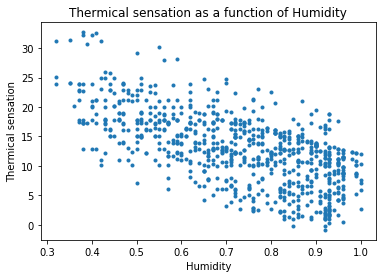

In [6]:
# display the data to get a better idea of what we are working with
plt.plot(X, Y, ".")
plt.title("Thermical sensation as a function of Humidity")
plt.xlabel("Humidity")
plt.ylabel("Thermical sensation")
# plt.savefig("graph_base.jpg")
plt.show()

### b) Model creation

In [7]:
percent_train = 0.8
size_dataset = len(data)

# divide input train and test
X_train = X[:int(size_dataset*percent_train)]
X_test = X[int(size_dataset*percent_train):]

# divide output train and test
Y_train = Y[:int(size_dataset*percent_train)]
Y_test = Y[int(size_dataset*percent_train):]

In [8]:
# create different values of p
p_array = np.linspace(0, 500, 100)

We are going to implement a lineal regression model with ridge regularization.

In [9]:
def reg_lineal(X, Y, p):
    """
        Returns the optimal parameter theta for the lineal regression.
        
        Arguments:
            X (array): training input
            Y (array): training output
            p (float): parameter to control the impact of the regularization
        
        Returns:
            theta_opt (array) : optimal parameter 
    """
    X1 = np.vstack([X,np.ones_like(X)]).T
    
    array_tmp = np.matmul(X1.T, Y)
    mat_tmp = np.matmul(X1.T, X1)
    # regularization
    mat_tmp += p*np.identity(mat_tmp.shape[0])
    
    theta = np.matmul(np.linalg.inv(mat_tmp), array_tmp)
    return theta

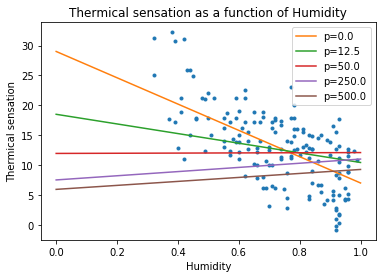

In [134]:
# smart p array contains the most diverse and interesting values of p
smart_p_array = [np.min(p_array), np.quantile(p_array, 0.025), np.quantile(p_array, 0.1), np.median(p_array), np.max(p_array)]

# plot
plt.plot(X_test, Y_test, ".")
for p in smart_p_array:
    theta = reg_lineal(X_train, Y_train, p)
    
    a, b = theta[0], theta[1]
    
    # plot the optimal lineal solution
    plt.plot([b, a+b], label="p="+str(p))
    plt.title("Thermical sensation as a function of Humidity")
    plt.xlabel("Humidity")
    plt.ylabel("Thermical sensation")
plt.legend()
# plt.savefig("graph_funcp.jpg")
plt.show()

In [225]:
def loss_classic_lr(theta, X, Y):
    a, b = theta[0], theta[1]
    y_pred = a * X + b
    loss = np.sum((y_pred - Y)**2)
    return loss

In [226]:
loss_classic_lr(theta=reg_lineal(X_train, Y_train, p=0), X=X_test, Y=Y_test)

3670.74456941582

### c) Coefficients with different p

Now we are going to plot the value of the parameters a,b (where $\theta = [a, b]$) given different values of $\rho$. a represents the slope and b the intercept.

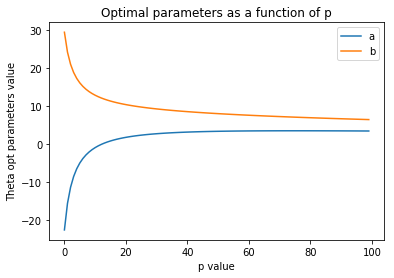

In [11]:
# stock the optimal parameters for all p
stock = list()
for p in p_array:
    stock.append(reg_lineal(X, Y, p))
stock = np.array(stock)

plt.plot(stock[:,0], label="a")
plt.plot(stock[:,1], label="b")
plt.title("Optimal parameters as a function of p")
plt.xlabel("p value")
plt.ylabel("Theta opt parameters value")
plt.legend()
# plt.savefig("graph_opt_params.jpg")
plt.show()

### Mean Squared error and variance

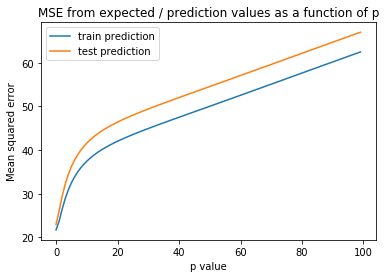

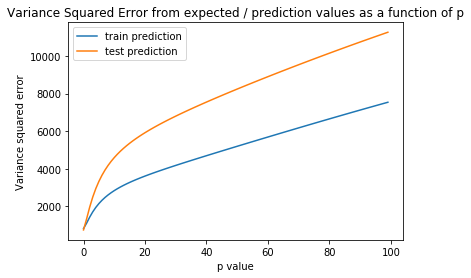

In [12]:
stock_mse_pred = list()
stock_var_pred = list()
for p in p_array:
    # calculate the optimal params
    theta = reg_lineal(X_train, Y_train, p)
    a, b = theta[0], theta[1]
    
    # prediction for test and train data
    Y_train_pred = a*X_train + b
    Y_test_pred = a*X_test + b
    
    # squared error
    se_train_pred = (Y_train_pred-Y_train)**2
    se_test_pred = (Y_test_pred-Y_test)**2

    # mean squared error
    mse_train_pred = np.mean(se_train_pred)
    mse_test_pred = np.mean(se_test_pred)

    # variance
    variance_train_pred = np.var(se_train_pred)
    variance_test_pred = np.var(se_test_pred)
    
    # stock
    stock_mse_pred.append([mse_train_pred, mse_test_pred])
    stock_var_pred.append([variance_train_pred, variance_test_pred])
stock_mse_pred = np.array(stock_mse_pred)
stock_var_pred = np.array(stock_var_pred)
    
# graph of mse predictions of train and test elements
plt.plot(stock_mse_pred[:, 0], label="train prediction")
plt.plot(stock_mse_pred[:, 1], label="test prediction")
plt.title("MSE from expected / prediction values as a function of p")
plt.xlabel("p value")
plt.ylabel("Mean squared error")
plt.legend()
# plt.savefig("graph_MSE.jpg")
plt.show()

# graph of vse predictions of train and test elements
plt.plot(stock_var_pred[:, 0], label="train prediction")
plt.plot(stock_var_pred[:, 1], label="test prediction")
plt.title("Variance Squared Error from expected / prediction values as a function of p")
plt.xlabel("p value")
plt.ylabel("Variance squared error")
plt.legend()
# plt.savefig("graph_VSE.jpg")
plt.show()

### Discussion and conclusion

## Exercice 3 - Personal project - Lineal Regression Orthogonal

Let us suppose we have a hiperplane $H$ which equation is : $\omega^T x + b = 0$ where $\theta = [\omega, b]^T$ and $||\theta||_2=1$.

For a given point $x_i$, we know there exists $\alpha_i \in \mathbb{R}$ such that $(x_i + \alpha_i \omega) \in H \Leftrightarrow \omega^T(x_i + \alpha_i \omega) +b = 0$.

This implies that $\alpha_i = - \dfrac{(\omega^T x_i+b)}{||\omega||^2_2}$.

We have that the orthogonal projection to the hiperplane of $x_i$ is $x_i^{\perp} = x_i - \dfrac{(\omega^T x_i+b)}{||\omega||^2_2} \omega$.

We have easily that $||x_i^{\perp} - x_i||^2_2 = (\omega^T x_i+b)^2 = (\theta^T \tilde{x_i})^2$.

We thus want to find the optimal hiperplane or the optimal parameter $\theta_{opt} = \underset{\theta , ||\omega||_2=1}{argmin}\big(\dfrac{1}{N}\displaystyle \sum_{i=1}^N (\theta^T \tilde{x_i})^2\big)$.

A strategy to rewrite this condition $||\omega||_2=1$ is to say that we just want that $||\omega||_2 \neq 0$. We can represent that term in the loss as $\dfrac{1}{||\omega||_2^2} + ||\omega||_2^2$. This should work out great.

Nonetheless we can be smarter and respect the condition $||\omega||_2 = 1$ in our optimization process. In order to achieve that, a solution is to put the function $\phi_p(\omega) = \begin{cases}
                                                 -\log(||\omega||_2^p) & \text{if $||\omega||_2^p \leq 1$} \\ 
                                                 ||\omega||_2^p & \text{otherwise}
                                                 \end{cases}$
                                                 
$p$ is a parameter that will put more importance to the condition $||\omega||_2=1$. We will use $p=2$ which should be fine.

The loss we will use is finally : $\mathcal{L_\theta} = \displaystyle \sum_{i=1}^N (\theta^T \tilde{x_i})^2 + \lambda \times \phi_2(\omega)$ where $\lambda$ is just another term to choose how important we want our constraint and regularization to be in the loss. 

In [51]:
import scipy
from scipy import optimize

In [44]:
x_input_train = np.vstack((X_train, Y_train, np.ones(len(X_train))))
x_input_test = np.vstack((X_test, Y_test,  np.ones(len(X_test))))
print(x_input_train.shape)
print(x_input_test.shape)
print(x_input_test.T[:5])

(3, 640)
(3, 160)
[[ 0.92       -0.86666667  1.        ]
 [ 0.99       10.91111111  1.        ]
 [ 0.93       11.18333333  1.        ]
 [ 0.59       17.85        1.        ]
 [ 0.87       14.96666667  1.        ]]


In [175]:
def phi(theta, p=2):
    norm_theta = np.sqrt(np.sum(theta**2))**p
    if norm_theta <= 1:
        return - np.log(norm_theta)
    else:
        return norm_theta

In [176]:
def loss_ortho_lr(theta, x, lambd, p):
    sum_part = np.sum(np.matmul(theta.T, x)**2)
    phi_part = lambd*phi(theta=theta, p=p)
    return sum_part + phi_part

In [241]:
def optimize_theta_ortho_lr(x, lambd, p, theta0 = [0.2, 6, 5]):
    """
        Return the optimal solution of theta for the problem.
        
        Arguments:
            x (array) : training data.
            lambd (float) : generally small, term to choose how important 
                we want our constraint and regularization to be in the loss.
            p (int) : power in the phi function, got the same function as lambd.
            
        Return:
            theta_opt (array) : optimized parameter to fit the model with the training data.
    """
    result = scipy.optimize.minimize(fun=loss_ortho_lr,
                            x0=theta0,
                            args=(x, lambd, p))
    print("OPT success status :", result.success)
    print("OPT message :", result.message)
    theta_opt = result.x
    return theta_opt

Evaluate the impact of lambd in the optimization.

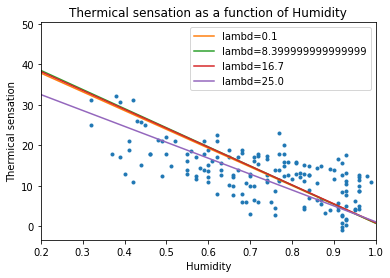

In [161]:
arr_lamb = np.linspace(0.1, 25, 4)
p = 2

plt.plot(X_test, Y_test, ".")
for lambd in arr_lamb:
    theta_opt = optimize_theta_ortho_lr(x=x_input_train, lambd=lambd, p=p)

    a, b = -theta_opt[0]/theta_opt[1], -theta_opt[2]/theta_opt[1]

    # plot the optimal lineal solution
    plt.plot([b, a+b], label="lambd="+str(lambd))
    plt.title("Thermical sensation as a function of Humidity")
    plt.xlabel("Humidity")
    plt.ylabel("Thermical sensation")
    plt.xlim((0.2, 1))
    plt.legend()
plt.show()

Evaluate the impact of p in the optimization.

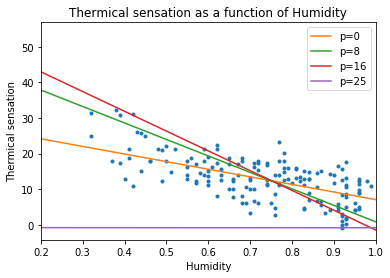

In [217]:
lambd = 1
arr_p = np.linspace(0.1, 25, 4, dtype=int)

plt.plot(X_test, Y_test, ".")
for p in arr_p:
    theta_opt = optimize_theta_ortho_lr(x=x_input_train, lambd=lambd, p=p)

    a, b = -theta_opt[0]/theta_opt[1], -theta_opt[2]/theta_opt[1]

    # plot the optimal lineal solution
    plt.plot([b, a+b], label="p="+str(p))
    plt.title("Thermical sensation as a function of Humidity")
    plt.xlabel("Humidity")
    plt.ylabel("Thermical sensation")
    plt.xlim((0.2, 1))
    plt.legend()
plt.show()

### Evaluation of the two models

OPT success status : True
OPT message : Optimization terminated successfully.
Classic loss with classic theta : 3670.74456941582
Classic loss with ortho theta : 3640.0968507221046
Ortho loss with classic theta : 3670.7445694158196
Ortho loss with ortho theta : 3640.096850722105
classic : [-22.01642632509197, 29.00542524293087]
ortho: [-24.292797544794233, 30.606045506439344]


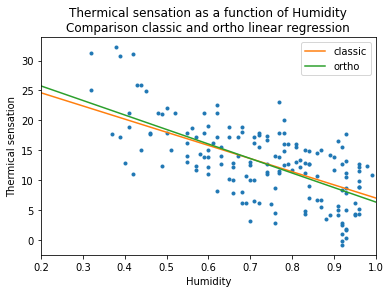

In [305]:
theta_classic_opt = reg_lineal(X_train, Y_train, p=0)
a_classic, b_classic = theta_classic_opt[0], theta_classic_opt[1]
theta_ortho_opt = optimize_theta_ortho_lr(x=x_input_train, lambd=1e-13, p=5)
a_ortho, b_ortho = -theta_ortho_opt[0]/theta_ortho_opt[1], -theta_ortho_opt[2]/theta_ortho_opt[1]

# classic
print("Classic loss with classic theta :", loss_classic_lr(theta=theta_classic_opt, X=X_test, Y=Y_test))
print("Classic loss with ortho theta :", loss_classic_lr(theta=[a_ortho, b_ortho], X=X_test, Y=Y_test))

# ortho
print("Ortho loss with classic theta :", loss_ortho_lr(theta=np.array([-a_classic, 1, -b_classic]), 
                x=x_input_test, 
              lambd=1, 
              p=0))
print("Ortho loss with ortho theta :", loss_ortho_lr(theta=np.array([-a_ortho, 1, -b_ortho]), 
                x=x_input_test, 
              lambd=1, 
              p=0))

# graph comparison
plt.plot(X_test, Y_test, ".")

print("classic :", [a_classic, b_classic])
print("ortho:", [a_ortho, b_ortho])

# plot the optimal lineal solution
plt.plot([b_classic, a_classic+b_classic], label="classic")
plt.plot([b_ortho, a_ortho+b_ortho], label="ortho")
plt.title("Thermical sensation as a function of Humidity\nComparison classic and ortho linear regression")
plt.xlabel("Humidity")
plt.ylabel("Thermical sensation")
plt.xlim((0.2, 1))
plt.legend()
plt.show()